# COBA and CUBA networks

The scripts ``COBA.py`` and ``CUBA.py``  in ``examples/vogels_abbott`` reproduce the two first benchmarks used in:

**Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al.** (2007), Simulation of networks of spiking neurons: a review of tools and strategies., *J. Comput. Neurosci., 23, 3, 349–98*

Both are based on the balanced network proposed by: 

**Vogels, T. P. and Abbott, L. F.** (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., *J. Neurosci., 25, 46, 10786–95*

The network is composed of 4000 neurons (3200 excitatory and 800 inhibitory), reciprocally connected with a probability of 0.02 (sparse connection).

The CUBA network uses a current-based integrate-and-fire neuron model:

$$\tau \cdot \frac{dv (t)}{dt} = E_l - v(t) + g_\text{exc} (t) - g_\text{inh} (t)$$

while the COBA model uses conductance-based IF neurons:

$$\tau \cdot \frac{dv (t)}{dt} = E_l - v(t) + g_\text{exc} (t) * (E_\text{exc}) - v(t)) + g_\text{inh} (t) * (E_\text{inh}) - v(t)) + I(t)$$
    
Apart from the neuron model and synaptic weights, both networks are equal, so we'll focus on the COBA network here.

The discretization step has to be set to 0.1 ms:

In [1]:
from ANNarchy import * 
setup(dt=0.1) 

ANNarchy 4.6 (4.6.7b) on linux (posix). 


## Neuron definition

In [2]:
COBA = Neuron(
    parameters="""
        El = -60.0          : population
        Vr = -60.0          : population
        Erev_exc = 0.0      : population
        Erev_inh = -80.0    : population
        Vt = -50.0          : population
        tau = 20.0          : population
        tau_exc = 5.0       : population
        tau_inh = 10.0      : population
        I = 20.0            : population
    """,
    equations="""
        tau * dv/dt = (El - v) + g_exc * (Erev_exc - v) + g_inh * (Erev_inh - v ) + I

        tau_exc * dg_exc/dt = - g_exc
        tau_inh * dg_inh/dt = - g_inh
    """,
    spike = "v > Vt",
    reset = "v = Vr",
    refractory = 5.0
)

In [3]:
CUBA = Neuron(
    parameters="""
        El = -49.0      : population
        Vr = -60.0      : population
        Vt = -50.0      : population
        tau_m = 20.0    : population
        tau_exc = 5.0   : population
        tau_inh = 10.0  : population
    """,
    equations="""
        tau_m * dv/dt = (El - v) + g_exc + g_inh 

        tau_exc * dg_exc/dt = - g_exc 
        tau_inh * dg_inh/dt = - g_inh 
    """,
    spike = "v > Vt",
    reset = "v = Vr",
    refractory = 5.0
)

The neurons define exponentially-decreasing conductance g_exc and g_inh for the excitatory and inhibitory conductances/currents, respectively.

They also define a refractory period of 5 ms.

## Population

In [4]:
P = Population(geometry=4000, neuron=COBA)
Pe = P[:3200]
Pi = P[3200:]

We create a population of 4000 COBA neurons, and assign the 3200 first ones to the excitatory population and the 800 last ones to the inhibitory population.

It would have been equivalent to declare two separate populations as:

```python
Pe = Population(geometry=3200, neuron=COBA)
Pi = Population(geometry= 800, neuron=COBA)
```

but splitting a global population allows to apply methods to all neurons, for example when recording all spikes with a single monitor, or when initializing populations parameters uniformly:

In [5]:
P.v = Normal(-55.0, 5.0)
P.g_exc = Normal(4.0, 1.5)
P.g_inh = Normal(20.0, 12.0)

## Connections

The neurons are randomly connected with a probability of 0.02. Excitatory neurons project on all other neurons with the target "exc" and a weight of 0.6, while the inhibitory neurons have the target "inh" and a weight of 6.7.

In [6]:
Ce = Projection(pre=Pe, post=P, target='exc')
Ce.connect_fixed_probability(weights=0.6, probability=0.02)

Ci = Projection(pre=Pi, post=P, target='inh')
Ci.connect_fixed_probability(weights=6.7, probability=0.02)


In [7]:
compile()

Compiling... 
OK 


## Simulation

We first define a monitor to record the spikes emitted in the whole population:

In [8]:
m = Monitor(P, ['spike'])

We can then simulate for 1 second:

In [9]:
simulate(1000.)

We retrieve the recorded spikes from the monitor:

In [10]:
data = m.get('spike')

and compute a raster plot from the data:

In [11]:
t, n = m.raster_plot(data)

`t` and `n` are lists representing for each spike emitted during the simulation the time at which it was emitted and the index the neuron which fired. The length of this list represents the total number of spikes in the popultion, so we can compute the population mean firing rate:

In [12]:
print('Mean firing rate in the population: ' + str(len(t) / 4000.) + 'Hz')

Mean firing rate in the population: 20.27775Hz


Finally, we can show the raster plot with pylab:

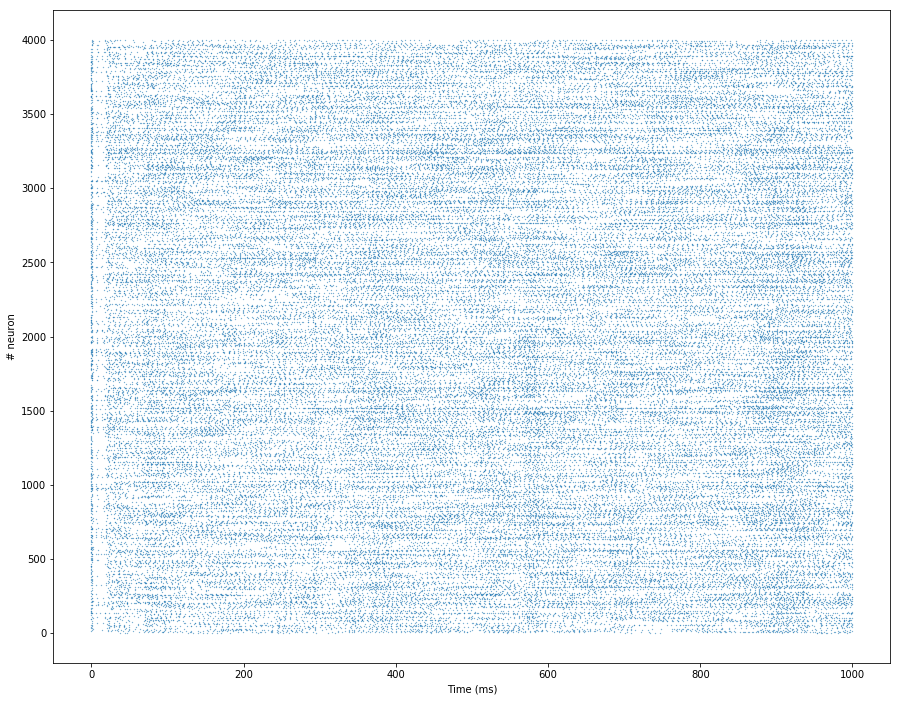

In [13]:
% matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
plt.plot(t, n, '.', markersize=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('# neuron')
plt.show()